In [1]:
import cv2
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator

#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [2]:
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [4]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

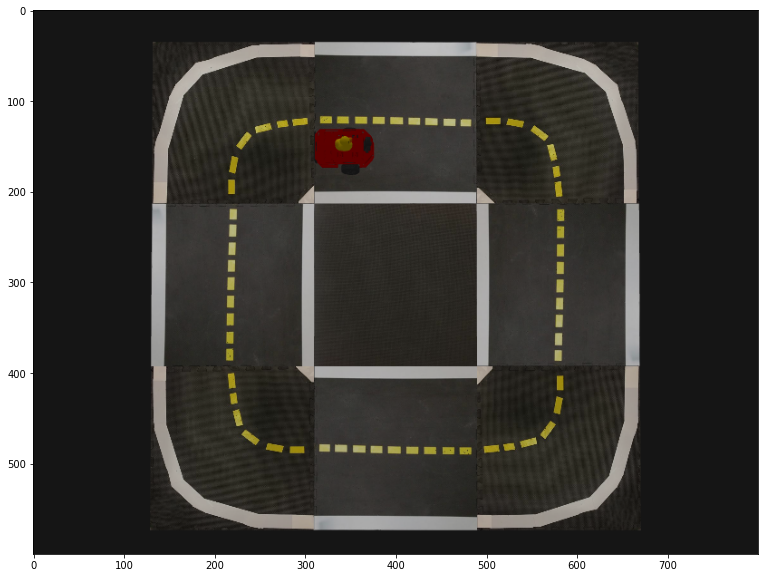

In [5]:
env.reset()
top_view = np.flip(env.render(mode="top_down"), [0])
plt.imshow(top_view)

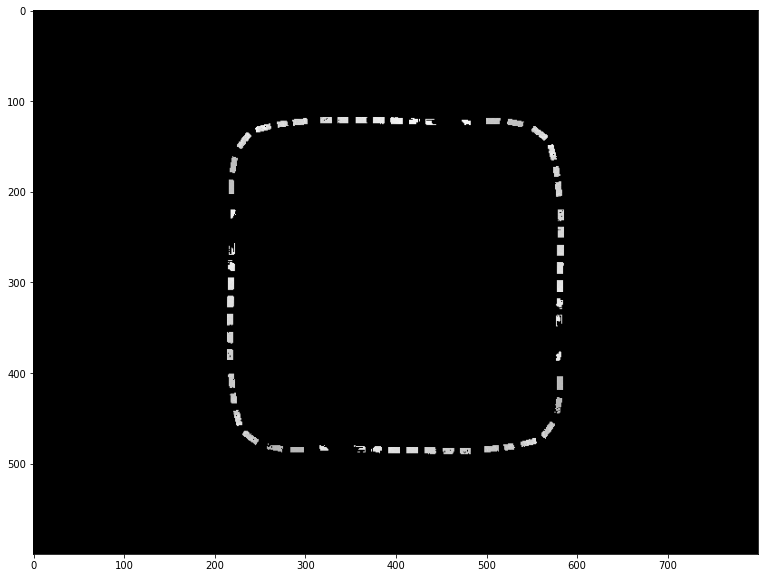

In [6]:
img_hsv = cv2.cvtColor(top_view, cv2.COLOR_RGB2HSV)
gray = cv2.cvtColor(top_view, cv2.COLOR_RGB2GRAY)

lower_yellow = np.array([20,100,150])
upper_yellow = np.array([30,255,255])

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask = cv2.bitwise_and(gray, mask_yellow)

plt.imshow(mask, cmap='gray')

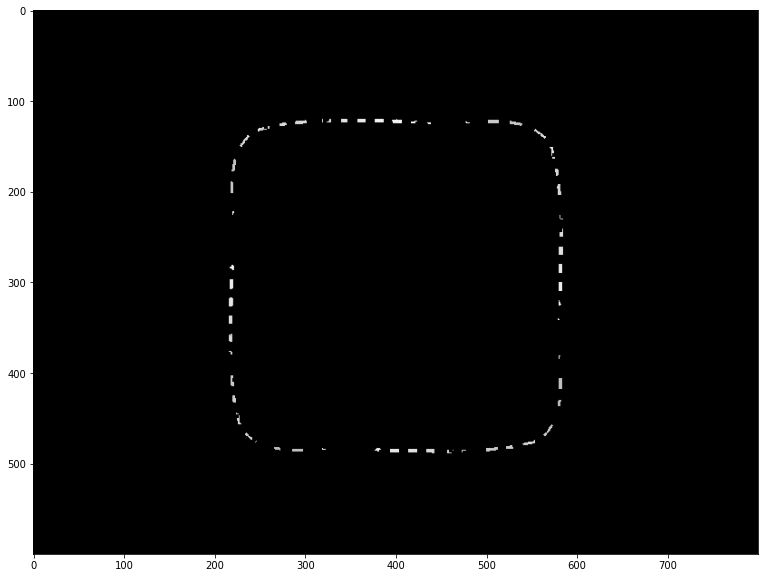

In [7]:
kernel = np.ones((4, 4), np.uint8)
eroded = cv2.erode(mask, kernel) 
plt.imshow(eroded, cmap='gray')

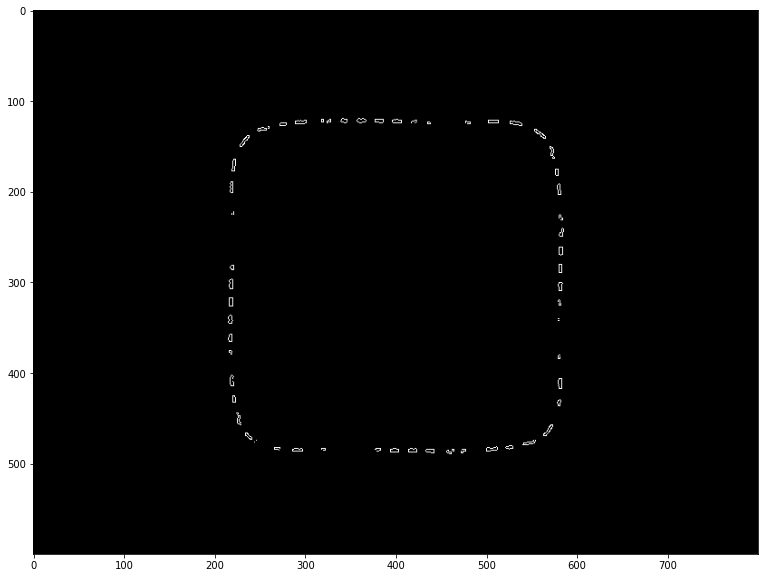

In [8]:
low_threshold = 89
high_threshold = 80
edges = cv2.Canny(eroded, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

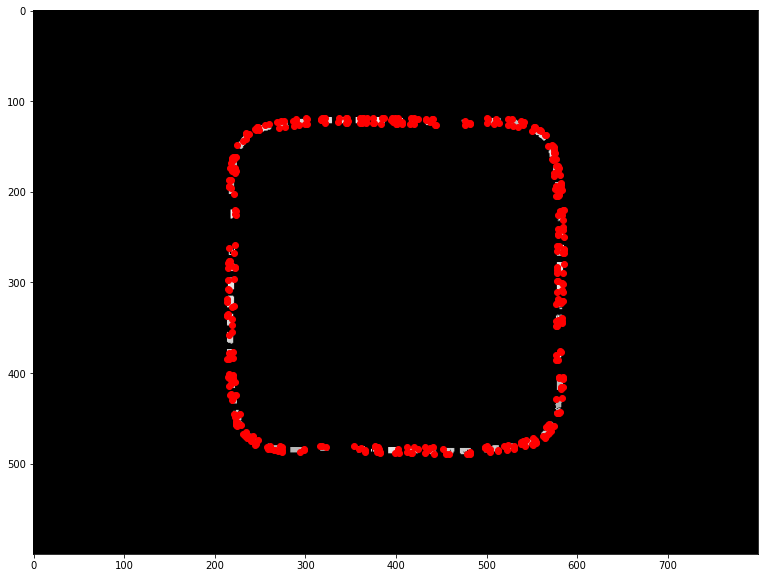

In [9]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 3  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10  # minimum number of pixels making up a line
max_line_gap = 50  # maximum gap in pixels between connectable line segments

lines = cv2.HoughLinesP(mask, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

_points = lines.reshape(-1, 2)

x, y = _points.T
plt.scatter(x, y, zorder=1, color="r")
plt.imshow(mask, zorder=0, cmap='gray')

In [10]:
def sort_xy(x, y):

    x0 = np.mean(x)
    y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    mask = np.argsort(angles)

    x_sorted = x[mask]
    y_sorted = y[mask]

    return x_sorted, y_sorted

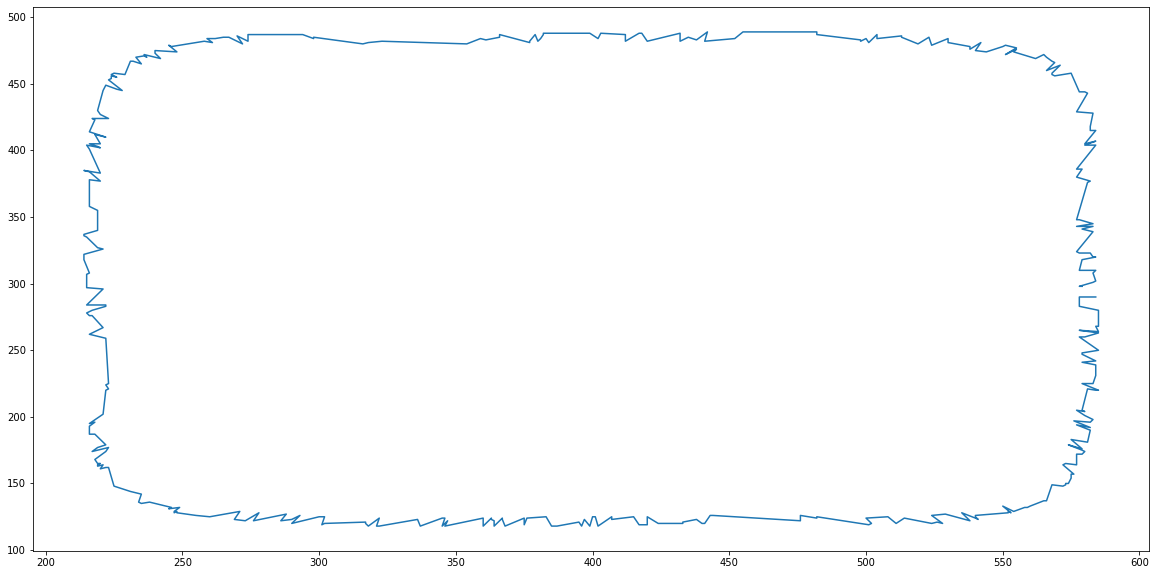

In [11]:
x_sorted, y_sorted = sort_xy(x, y)
plt.plot(x_sorted, y_sorted)

In [12]:
from scipy.interpolate import interp1d

Text(0, 0.5, 'y')

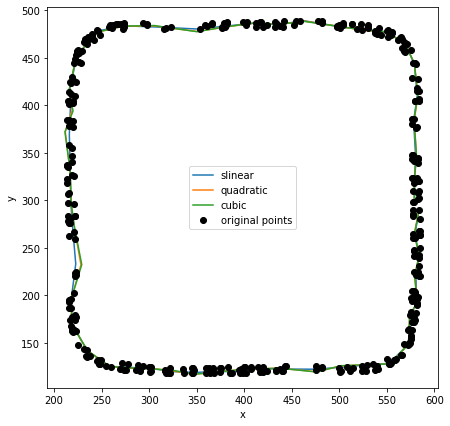

In [13]:
points = np.array([x_sorted, y_sorted]).T  # a (nbre_points x nbre_dim) array

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Interpolation for different methods:
interpolations_methods = ['slinear', 'quadratic', 'cubic']
alpha = np.linspace(0, 1, 50)

interpolated_points = {}
for method in interpolations_methods:
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:
plt.figure(figsize=(7,7))
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '-', label=method_name)

plt.plot(*points.T, 'ok', label='original points')
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y')

In [14]:
from scipy.interpolate import UnivariateSpline

/tmp/ipykernel_45945/597672607.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


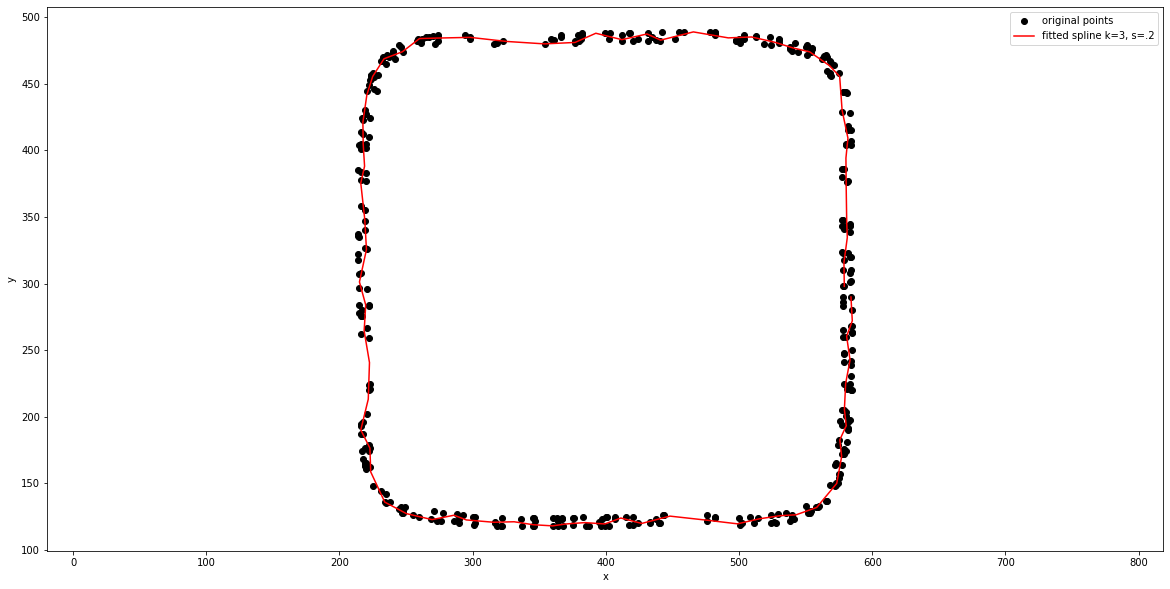

In [21]:
points = np.array([x_sorted, y_sorted]).T

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Build a list of the spline function, one for each dimension:
splines = [UnivariateSpline(distance, coords, k=1, s=.01) for coords in points.T]

# Computed the spline for the asked distances:
alpha = np.linspace(0, 1, 75)
points_fitted = np.vstack( spl(alpha) for spl in splines ).T

# Graph:
plt.plot(*points.T, 'ok', label='original points');
plt.plot(*points_fitted.T, '-r', label='fitted spline k=3, s=.2');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');